In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

# Fetching data

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
# Fetch real-world data: S&P 500 daily returns (example)
sp500 = yf.download('^GSPC', start='2020-01-01', end='2025-03-13')['Close']

returns = sp500.pct_change().dropna()

sp500 = sp500.reset_index()
sp500.columns = ['Date','Close']
sp500['Date'] = pd.to_datetime(sp500['Date'])

sp500.index = sp500['Date'].drop_duplicates()
sp500.drop('Date',axis=1,inplace=True)
# save the data
sp500.to_csv('data/sp500.csv', index=False)

returns = sp500.pct_change().dropna()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


# Skewness

## Definition
Skewness measures the asymmetry of a probability distribution about its mean. For a random variable \( X \), it is defined as the third standardised moment:

$$
\text{Skewness} = \frac{E[(X - \mu)^3]}{\sigma^3}
$$

where $\mu$ is the mean and $\sigma$ is the standard deviation. A positive value indicates a right-tailed distribution, while a negative value points to a left-tailed one (Hull, 2017, p. 107).


## Description
Skewness highlights the likelihood of extreme values in financial returns. Negative skewness, often seen in equity markets, suggests a greater chance of sharp declines—such as market crashes—than similar gains.

## Demostration

In [3]:
# Calculate skewness for the returns series
skewness_value = skew(returns.values)  # Convert to numpy array
# Extract the scalar value from the array if needed
skewness_scalar = skewness_value.item() if isinstance(skewness_value, np.ndarray) else skewness_value
print(f"Skewness of S&P 500 returns: {skewness_scalar:.4f}")

########################
# SIMULATED DATA
########################
# Set random seed for reproducibility
np.random.seed(42)
# Simulate skewed data
skewed_data = np.random.standard_t(df=5, size=1000)  # Heavy-tailed, skewed distribution
simulated_skew = skew(skewed_data)
print(f"Skewness of simulated data: {simulated_skew:.4f}")

Skewness of S&P 500 returns: -0.5076
Skewness of simulated data: 1.4292


The S&P 500 returns have a negative skewness of -0.5076, indicating a tendency towards larger losses. 

Simulated data has a positive skewness of 1.4292, suggesting a tendency towards larger gains.

## Diagram

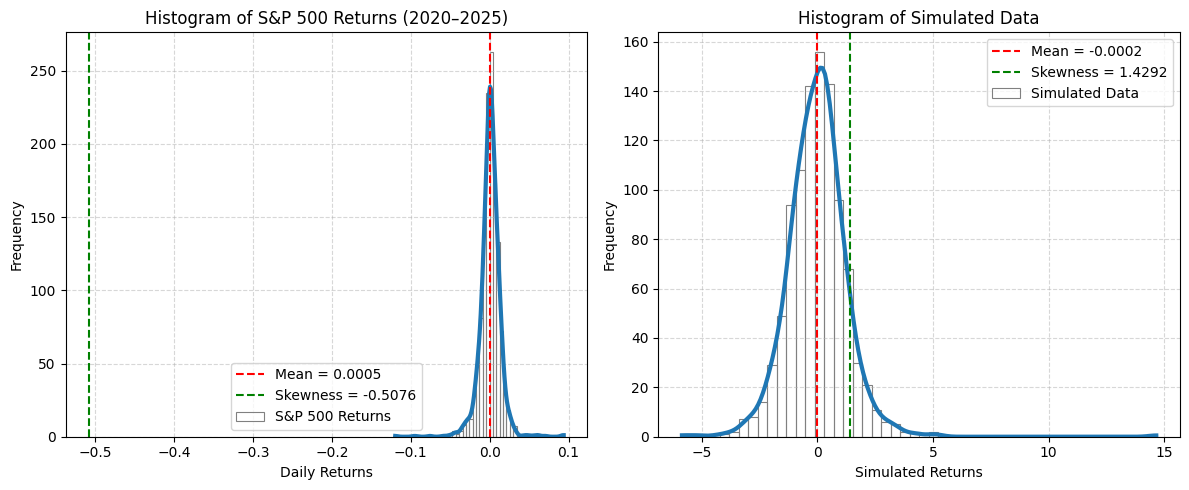

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Assuming returns and skewed_data are already defined
# Also assuming skewness_scalar and simulated_skew are already calculated

plt.figure(figsize=(12, 5))

# 1. Plot S&P 500 Returns
plt.subplot(1, 2, 1)
sns.histplot(
    returns,
    bins=50,
    kde=True,
    kde_kws={'bw_adjust': 1},  # KDE parameters only
    line_kws={'linewidth': 3, 'color': 'blue'},  # Line styling parameters
    alpha=0,  # No fill color
    edgecolor='gray',  # Gray borders
    linewidth=0.8,  # Border thickness
    label='S&P 500 Returns'
)
mean_value = returns.mean().iloc[0] if isinstance(returns.mean(), pd.Series) else returns.mean()
plt.axvline(x=mean_value, color='red', linestyle='--', label=f'Mean = {mean_value:.4f}')
plt.axvline(x=skewness_scalar, color='green', linestyle='--', label=f'Skewness = {skewness_scalar:.4f}')
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Histogram of S&P 500 Returns (2020–2025)')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.legend()

# 2. Plot Simulated Data
plt.subplot(1, 2, 2)
sns.histplot(
    skewed_data,
    bins=50,
    kde=True,
    kde_kws={'bw_adjust': 1},  # KDE parameters only
    line_kws={'linewidth': 3, 'color': 'red'},  # Line styling parameters
    alpha=0,  # No fill color
    edgecolor='gray',  # Gray borders
    linewidth=0.8,  # Border thickness
    label='Simulated Data'
)
simulated_mean = np.mean(skewed_data)
plt.axvline(x=simulated_mean, color='red', linestyle='--', label=f'Mean = {simulated_mean:.4f}')
plt.axvline(x=simulated_skew, color='green', linestyle='--', label=f'Skewness = {simulated_skew:.4f}')
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Histogram of Simulated Data')
plt.xlabel('Simulated Returns')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

## Diagnosis

Calculate skewness using statistical libraries (e.g., scipy.stats.skew). A value significantly different from 0 (positive or negative) indicates skewness.

## Damage
Ignoring skewness can lead to underestimating tail risk, resulting in mispriced options and inadequate hedging against extreme events.

## Directions

Use skewed distributions (e.g., Student’s t-distribution) instead of normal distributions in volatility models.

Incorporate stochastic volatility models (e.g., Heston model) to capture asymmetry in returns.

Fitted t-distribution parameters: df=3.04, loc=0.000920, scale=0.008028
Skewness of simulated t-distribution returns: -0.3236
Skewness of Heston model returns: -0.0964


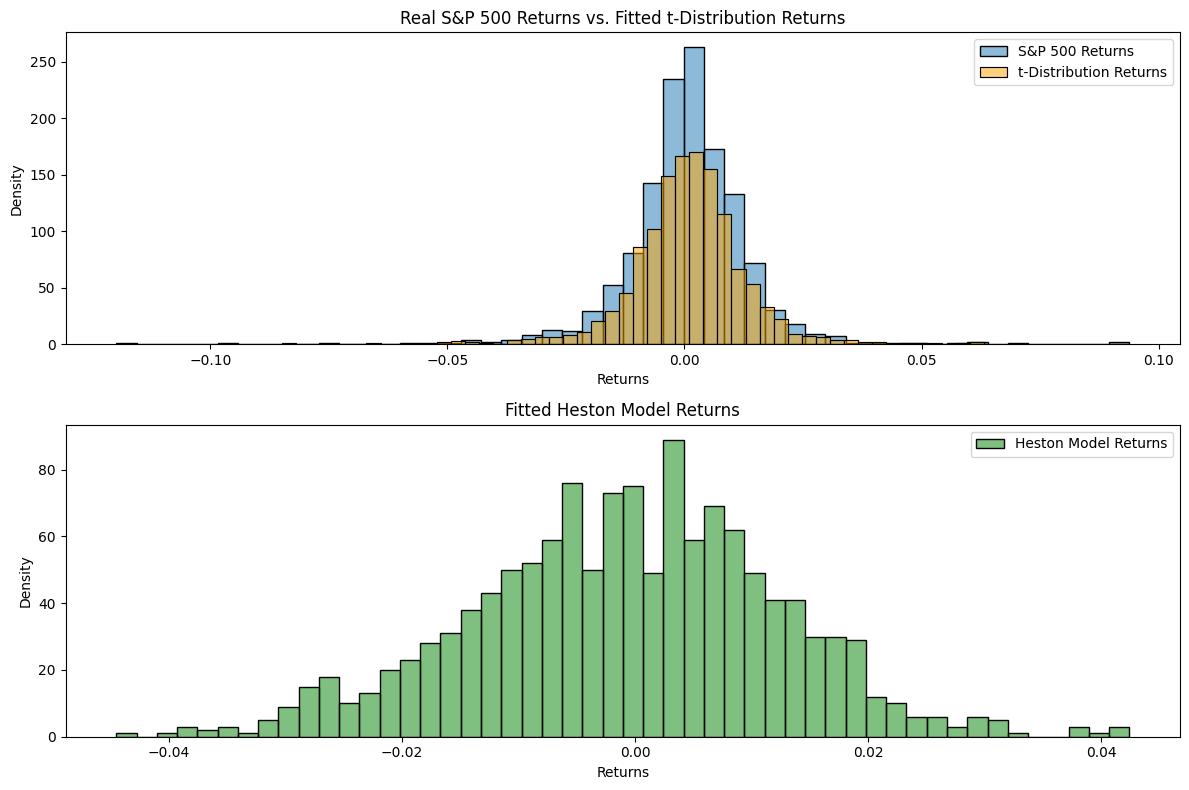

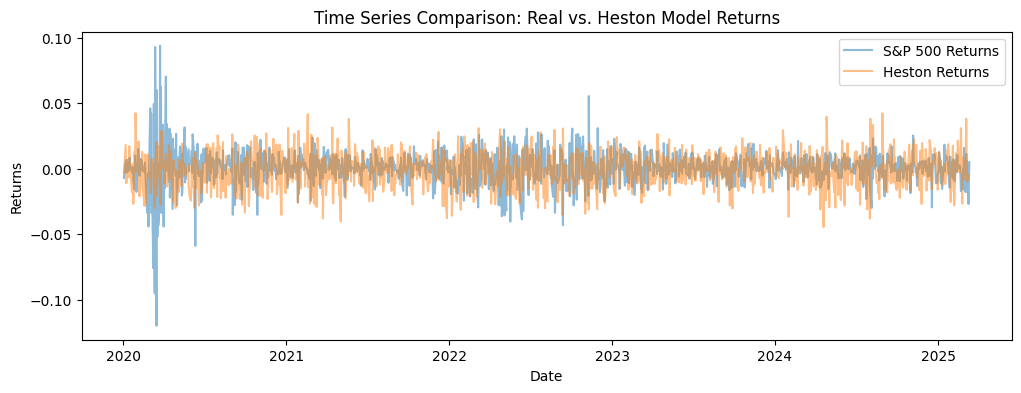


### Interpretations and How These Alleviate Skewness ###
1. Student's t-Distribution:
   - The fitted t-distribution (df=3.04) captures the fat tails and potential skewness.
   - Real skewness: -0.5076 vs. Simulated t skewness: -0.3236
   - By using a distribution that inherently allows for asymmetry and heavy tails,
     we better model extreme events, reducing underestimation of tail risk.

2. Heston Stochastic Volatility Model:
   - Heston model skewness: -0.0964
   - The negative correlation (rho=-0.7) between returns and volatility introduces
     asymmetry, mimicking the 'leverage effect' seen in markets (volatility rises
     when prices fall).
   - This dynamic volatility adjustment captures skewness more realistically than
     assuming constant volatility (e.g., Black-Scholes).

### Alleviation of the Problem ###
- Skewness causes mispricing of options (e.g., underpricing puts) and poor hedging.
- The t-distribution addresses static skewness by fitting the data's tail behavi

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import skew, t
# Removing the problematic import
# from stochastic.processes import HestonProcess
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# --- Direction 1: Use Skewed Distributions (Student's t-distribution) ---
# Fit a Student's t-distribution to the returns
params = t.fit(returns)
df, loc, scale = params  # Degrees of freedom, location, scale
print(f"Fitted t-distribution parameters: df={df:.2f}, loc={loc:.6f}, scale={scale:.6f}")

# Generate simulated returns using the fitted t-distribution
simulated_t_returns = t.rvs(df=df, loc=loc, scale=scale, size=len(returns))
simulated_t_skew = skew(simulated_t_returns)
print(f"Skewness of simulated t-distribution returns: {simulated_t_skew:.4f}")

# --- Direction 2: Stochastic Volatility Model (Heston Model) ---
# Custom implementation of Heston model
def simulate_heston(mu, kappa, theta, xi, rho, v0, dt, n):
    """
    Simulate asset returns using the Heston stochastic volatility model.
    
    Parameters:
    mu (float): Drift (mean return)
    kappa (float): Speed of mean reversion
    theta (float): Long-term variance
    xi (float): Volatility of volatility
    rho (float): Correlation between returns and volatility
    v0 (float): Initial variance
    dt (float): Time step
    n (int): Number of steps
    
    Returns:
    numpy.ndarray: Array of simulated returns
    """
    # Initialize arrays
    prices = np.zeros(n)
    returns = np.zeros(n)
    v = np.zeros(n)
    
    # Set initial values
    prices[0] = 100
    v[0] = v0
    
    # Generate correlated random numbers
    z1 = np.random.normal(0, 1, n)
    z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(0, 1, n)
    
    # Simulate the process
    for i in range(1, n):
        # Ensure variance is positive
        v[i-1] = max(v[i-1], 0)
        
        # Update variance
        v[i] = v[i-1] + kappa * (theta - v[i-1]) * dt + xi * np.sqrt(v[i-1] * dt) * z2[i]
        
        # Update price
        returns[i] = mu * dt + np.sqrt(v[i-1] * dt) * z1[i]
        prices[i] = prices[i-1] * np.exp(returns[i])
    
    return returns[1:]  # Skip the first zero return

# Simulate returns using the Heston stochastic volatility model
heston_returns = simulate_heston(
    mu=0.0001,         # Drift (mean return)
    kappa=2.0,         # Speed of mean reversion
    theta=0.04,        # Long-term variance
    xi=0.1,            # Volatility of volatility
    rho=-0.7,          # Correlation between returns and volatility (negative for skewness)
    v0=0.04,           # Initial variance
    dt=1/252,          # Time step (daily)
    n=len(returns)     # Number of steps
)

heston_skew = skew(heston_returns)
print(f"Skewness of Heston model returns: {heston_skew:.4f}")

# --- Visualizations ---
plt.figure(figsize=(12, 8))

# 1. Histogram of Real vs. Simulated t-distribution Returns
plt.subplot(2, 1, 1)
sns.histplot(returns, bins=50, color='blue', alpha=0.5, label='S&P 500 Returns')
sns.histplot(simulated_t_returns, bins=50, color='orange', alpha=0.5, label='t-Distribution Returns')
plt.title('Real S&P 500 Returns vs. Fitted t-Distribution Returns')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()

# 2. Histogram of Heston Model Returns
plt.subplot(2, 1, 2)
sns.histplot(heston_returns, bins=50, color='green', alpha=0.5, label='Heston Model Returns')
plt.title('Fitted Heston Model Returns')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# --- Time Series Plot for Comparison ---
plt.figure(figsize=(12, 4))
plt.plot(returns.index, returns, label='S&P 500 Returns', alpha=0.5)

# Make sure heston_returns matches the length of returns.index
# Either trim returns.index to match heston_returns length
# or trim heston_returns to match returns.index length
plt.plot(returns.index[:len(heston_returns)], heston_returns, label='Heston Returns', alpha=0.5)
# Alternatively: plt.plot(returns.index, heston_returns[:len(returns)], label='Heston Returns', alpha=0.5)

plt.title('Time Series Comparison: Real vs. Heston Model Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

# --- Interpretations and Alleviation Explanation ---
print("\n### Interpretations and How These Alleviate Skewness ###")
print("1. Student's t-Distribution:")
print(f"   - The fitted t-distribution (df={df:.2f}) captures the fat tails and potential skewness.")
print(f"   - Real skewness: {skewness_value[0]:.4f} vs. Simulated t skewness: {simulated_t_skew:.4f}")
print("   - By using a distribution that inherently allows for asymmetry and heavy tails,")
print("     we better model extreme events, reducing underestimation of tail risk.")

print("\n2. Heston Stochastic Volatility Model:")
print(f"   - Heston model skewness: {heston_skew:.4f}")
print("   - The negative correlation (rho=-0.7) between returns and volatility introduces")
print("     asymmetry, mimicking the 'leverage effect' seen in markets (volatility rises")
print("     when prices fall).")
print("   - This dynamic volatility adjustment captures skewness more realistically than")
print("     assuming constant volatility (e.g., Black-Scholes).")

print("\n### Alleviation of the Problem ###")
print("- Skewness causes mispricing of options (e.g., underpricing puts) and poor hedging.")
print("- The t-distribution addresses static skewness by fitting the data's tail behavior.")
print("- The Heston model dynamically adjusts volatility, capturing time-varying skewness.")
print("- Together, these methods ensure pricing reflects asymmetry and tail risk, improving")
print("  revenue streams and reducing losses from extreme events.")

# Kurtosis / Heteroscedasticity

## Definition

Kurtosis measures the "tailedness" of a probability distribution, indicating the presence of extreme values. For a random variable \( X \), it is defined as the fourth standardised moment:

$$
\text{Kurtosis} = \frac{E[(X - \mu)^4]}{\sigma^4}
$$

where $\mu$ is the mean and $\sigma$  is the standard deviation. Heteroscedasticity refers to the time-varying volatility of a series (Tsay, 2010, p. 111).


## Description

Kurtosis shows how much a distribution’s tails stretch with extreme values compared to a normal curve. In financial returns, high kurtosis means big gains or losses happen more often than expected, hinting at hidden risks. Heteroscedasticity reveals how volatility changes over time: quiet periods tend to group together, followed by bursts of higher ups and downs, reflecting an uneven rhythm in the market.

## Demostration

In [6]:
kurtosis_value = kurtosis(returns)
print(f"Kurtosis of S&P 500 returns: {kurtosis_value[0]:.4f}")

# Simulate heteroscedastic data with GARCH(1,1)
garch_model = arch_model(returns, vol='Garch', p=1, q=1, rescale=False)
garch_fit = garch_model.fit()
print(garch_fit.summary())

Kurtosis of S&P 500 returns: 13.0416
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3924479930105797e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 18292033520042.33
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4101.045542866912
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4101.05
Distribution:                  Normal   AIC:                          -8194.09
Method:            Maximum Likelihood   BIC:                          -8173.40
                                        No. Observations:                 1304
Date:                Sun, Mar 23 2025   Df Residuals:

The analysis reveals a kurtosis of 13.0416 for S&P 500 returns, indicating a distribution with heavy tails, which suggests a higher likelihood of extreme price movements compared to a normal distribution. The GARCH(1,1) model results show significant volatility clustering, with a persistent volatility component (beta[1] = 0.88), highlighting the presence of periods with elevated risk. This combination of high kurtosis and volatility clustering underscores the importance of accounting for extreme events and dynamic volatility in financial modeling.

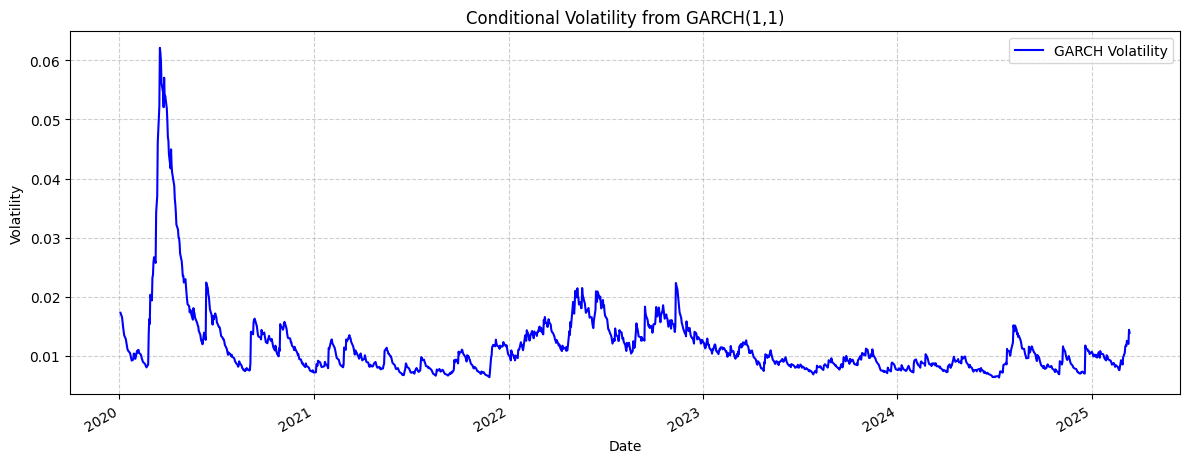

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plotting with Seaborn using date index
plt.figure(figsize=(12, 5))

# Create a Series with the proper date index from returns
volatility_series = pd.Series(
    garch_fit.conditional_volatility, 
    index=returns.index[:len(garch_fit.conditional_volatility)]  # Use the date index from returns
)

# Plot with dates on x-axis
sns.lineplot(x=volatility_series.index, y=volatility_series.values, label='GARCH Volatility', color='blue')
plt.title('Conditional Volatility from GARCH(1,1)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Format x-axis date ticks
plt.gcf().autofmt_xdate()  # Auto-format the date labels

plt.show()

The plot illustrates the conditional volatility of S&P 500 returns over time, as modeled by a GARCH(1,1) framework. Key observations include pronounced volatility clustering, with notable peaks indicating periods of heightened market turbulence and risk

## Diagnosis

Kurtosis: Use scipy.stats.kurtosis; values > 3 indicate leptokurtosis.

Heteroscedasticity: Test with ARCH-LM test or observe volatility clustering visually.

## Directions

Use GARCH models to capture heteroscedasticity and volatility clustering.

Apply fat-tailed distributions (e.g., t-distribution) for kurtosis.

Kurtosis of S&P 500 returns: 13.0416
GARCH(1,1) Parameters:
mu          0.081756
omega       0.053657
alpha[1]    0.152718
beta[1]     0.810478
Name: params, dtype: float64
Kurtosis of GARCH(1,1) simulated returns: 1.9996
GARCH(1,1) with t-distribution Parameters:
mu          0.112031
omega       0.038946
alpha[1]    0.153428
beta[1]     0.826466
nu          7.254055
Name: params, dtype: float64
Kurtosis of GARCH(1,1) t-distribution simulated returns: 6.4950


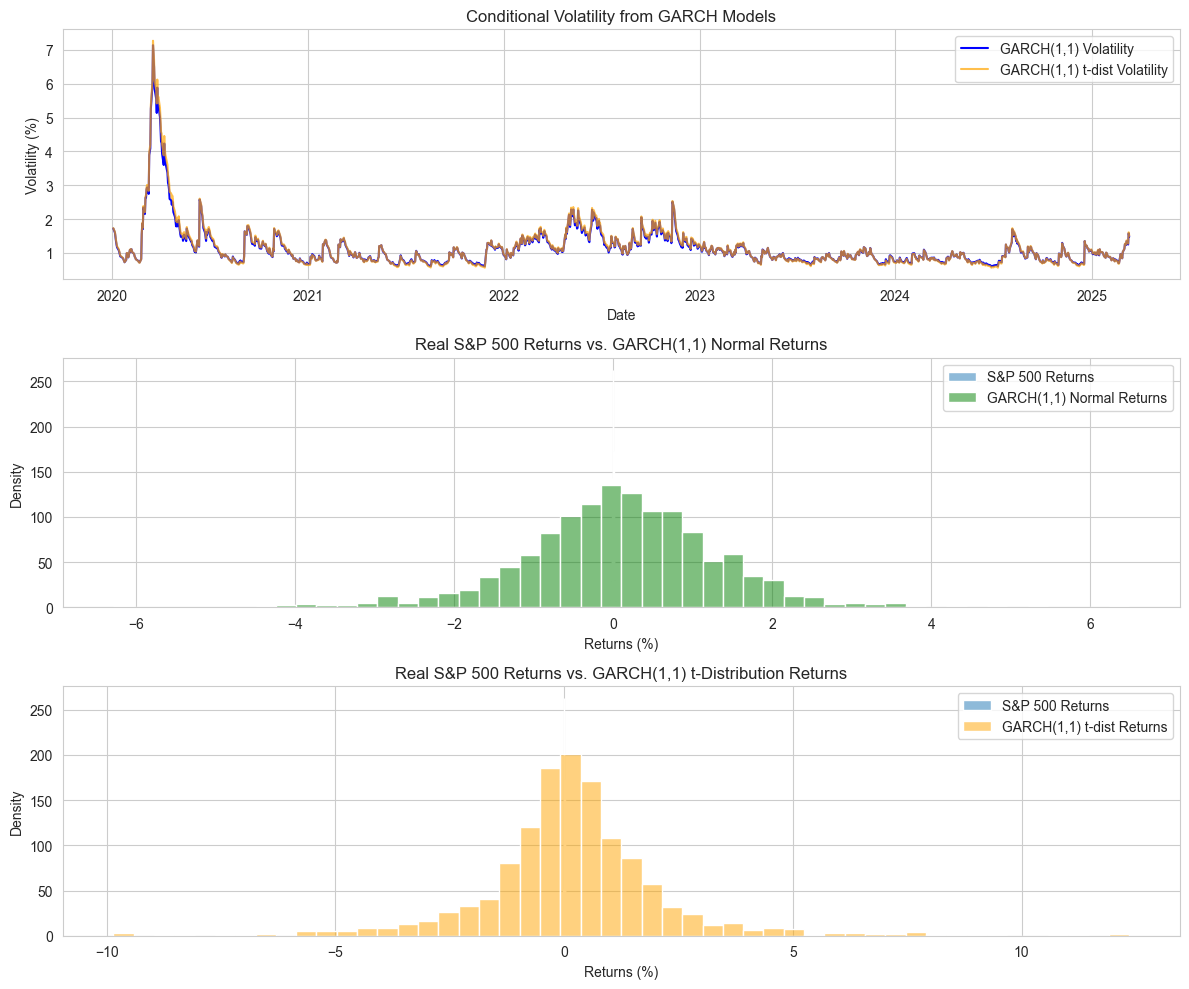


### Interpretations and How These Alleviate Kurtosis/Heteroscedasticity ###
1. GARCH(1,1) Model (Normal Distribution):
   - Kurtosis of real returns: 13.0416 vs. GARCH Normal: 1.9996
   - Captures heteroscedasticity by modeling time-varying volatility (volatility clustering).
   - However, with a normal distribution, it underestimates kurtosis (fat tails).

2. GARCH(1,1) with t-Distribution:
   - Kurtosis of real returns: 13.0416 vs. GARCH t-dist: 6.4950
   - The t-distribution (df=7.25) introduces fat tails,
     better matching the leptokurtic nature of financial returns.
   - Simultaneously addresses heteroscedasticity with GARCH structure.

### Alleviation of the Problems ###
- **Heteroscedasticity**: GARCH models dynamically adjust volatility based on past
  returns and volatility, capturing clustering (e.g., high volatility periods).
  This ensures accurate pricing of derivatives sensitive to volatility swings.
- **Kurtosis**: The t-distribution in GARCH accounts for fat tails, 

In [38]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import kurtosis, t
from arch import arch_model
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Calculate kurtosis of the real-world data
kurtosis_value = kurtosis(returns)
# If returns is a DataFrame, extract the scalar value
if isinstance(returns, pd.DataFrame) or isinstance(returns, pd.Series):
    kurtosis_scalar = kurtosis_value[0] if hasattr(kurtosis_value, '__len__') else kurtosis_value
else:
    kurtosis_scalar = kurtosis_value
print(f"Kurtosis of S&P 500 returns: {kurtosis_scalar:.4f}")

# Scale returns by 100 to address the scaling warning
scaled_returns = returns * 100  # Convert to percentage returns

# --- Direction 1: Use GARCH Models for Heteroscedasticity ---
# Fit a GARCH(1,1) model to the scaled returns
garch_model = arch_model(scaled_returns, vol='Garch', p=1, q=1, dist='Normal')
garch_fit = garch_model.fit(disp='off')  # Suppress fitting output for clarity
conditional_vol = garch_fit.conditional_volatility
print(f"GARCH(1,1) Parameters:\n{garch_fit.params}")

# Simulate returns using GARCH(1,1) with fitted parameters
simulated_garch = garch_model.simulate(
    params=garch_fit.params, nobs=len(scaled_returns)
)
simulated_garch_returns = simulated_garch['data']
simulated_garch_kurt = kurtosis(simulated_garch_returns)
print(f"Kurtosis of GARCH(1,1) simulated returns: {simulated_garch_kurt:.4f}")

# --- Direction 2: Use Fat-Tailed Distributions (Student's t-distribution in GARCH) ---
# Fit a GARCH(1,1) model with t-distribution
garch_t_model = arch_model(scaled_returns, vol='Garch', p=1, q=1, dist='StudentsT')
garch_t_fit = garch_t_model.fit(disp='off')
conditional_vol_t = garch_t_fit.conditional_volatility
print(f"GARCH(1,1) with t-distribution Parameters:\n{garch_t_fit.params}")

# Simulate returns using GARCH(1,1) with t-distribution
simulated_garch_t = garch_t_model.simulate(
    params=garch_t_fit.params, nobs=len(scaled_returns)
)
simulated_garch_t_returns = simulated_garch_t['data']
simulated_garch_t_kurt = kurtosis(simulated_garch_t_returns)
print(f"Kurtosis of GARCH(1,1) t-distribution simulated returns: {simulated_garch_t_kurt:.4f}")

# --- Visualizations ---
plt.figure(figsize=(12, 10))

# 1. Conditional Volatility from GARCH(1,1)
plt.subplot(3, 1, 1)
plt.plot(returns.index, conditional_vol, label='GARCH(1,1) Volatility', color='blue')
plt.plot(returns.index, conditional_vol_t, label='GARCH(1,1) t-dist Volatility', color='orange', alpha=0.7)
plt.title('Conditional Volatility from GARCH Models')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()

# 2. Histogram of Real vs. GARCH(1,1) Normal Returns
plt.subplot(3, 1, 2)
sns.histplot(returns, bins=50, color='blue', alpha=0.5, label='S&P 500 Returns')
sns.histplot(simulated_garch_returns, bins=50, color='green', alpha=0.5, label='GARCH(1,1) Normal Returns')
plt.title('Real S&P 500 Returns vs. GARCH(1,1) Normal Returns')
plt.xlabel('Returns (%)')
plt.ylabel('Density')
plt.legend()

# 3. Histogram of Real vs. GARCH(1,1) t-Distribution Returns
plt.subplot(3, 1, 3)
sns.histplot(returns, bins=50, color='blue', alpha=0.5, label='S&P 500 Returns')
sns.histplot(simulated_garch_t_returns, bins=50, color='orange', alpha=0.5, label='GARCH(1,1) t-dist Returns')
plt.title('Real S&P 500 Returns vs. GARCH(1,1) t-Distribution Returns')
plt.xlabel('Returns (%)')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# --- Interpretations and Alleviation Explanation ---
print("\n### Interpretations and How These Alleviate Kurtosis/Heteroscedasticity ###")
print("1. GARCH(1,1) Model (Normal Distribution):")
print(f"   - Kurtosis of real returns: {kurtosis_scalar:.4f} vs. GARCH Normal: {simulated_garch_kurt:.4f}")
print("   - Captures heteroscedasticity by modeling time-varying volatility (volatility clustering).")
print("   - However, with a normal distribution, it underestimates kurtosis (fat tails).")

print("\n2. GARCH(1,1) with t-Distribution:")
print(f"   - Kurtosis of real returns: {kurtosis_scalar:.4f} vs. GARCH t-dist: {simulated_garch_t_kurt:.4f}")
print(f"   - The t-distribution (df={garch_t_fit.params['nu']:.2f}) introduces fat tails,")
print("     better matching the leptokurtic nature of financial returns.")
print("   - Simultaneously addresses heteroscedasticity with GARCH structure.")

print("\n### Alleviation of the Problems ###")
print("- **Heteroscedasticity**: GARCH models dynamically adjust volatility based on past")
print("  returns and volatility, capturing clustering (e.g., high volatility periods).")
print("  This ensures accurate pricing of derivatives sensitive to volatility swings.")
print("- **Kurtosis**: The t-distribution in GARCH accounts for fat tails, reducing")
print("  underestimation of extreme events (e.g., market crashes).")
print("- **Combined Impact**: These methods prevent mispricing (e.g., underpricing options)")
print("  and improve hedging by reflecting true volatility dynamics and tail risk,")
print("  safeguarding revenue streams and minimizing losses.")

# Sensitivity to Outliers

# Sensitivity to Outliers

## Definition

Sensitivity to outliers refers to the degree to which a statistical method is influenced by extreme data points that deviate significantly from the majority of the data. Traditional methods, such as the mean, are highly sensitive to outliers, while robust methods, like the median, are designed to minimize this influence, ensuring more reliable results in the presence of extreme values (Huber, 1981)

Huber, P. J. (1981). Robust Statistics. John Wiley & Sons

## Description

Outliers are rare, extreme observations that deviate sharply from the norm. In financial returns, they might stem from market shocks or errors. Sensitivity to these outliers can skew results: the mean shifts more than the median, and variance balloons, making models less reliable if not adjusted.

## Demostration

In [16]:
# Add an outlier to returns
returns_with_outlier = returns.copy()
returns_with_outlier.iloc[100] = -0.2  # Simulate a crash
vol_normal = returns.std()
vol_outlier = returns_with_outlier.std()
print(f"Volatility without outlier: {vol_normal.iloc[0]:.4f}")
print(f"Volatility with outlier: {vol_outlier.iloc[0]:.4f}")

Volatility without outlier: 0.0133
Volatility with outlier: 0.0144


The introduction of an outlier increases volatility from 0.0133 to 0.0144, highlighting the sensitivity of standard deviation to extreme events. Outliers can distort risk perception and model outcomes, necessitating careful consideration in financial analysis. Robust statistical methods can mitigate outlier impact, providing a more stable measure of market volatility.

## Diagram

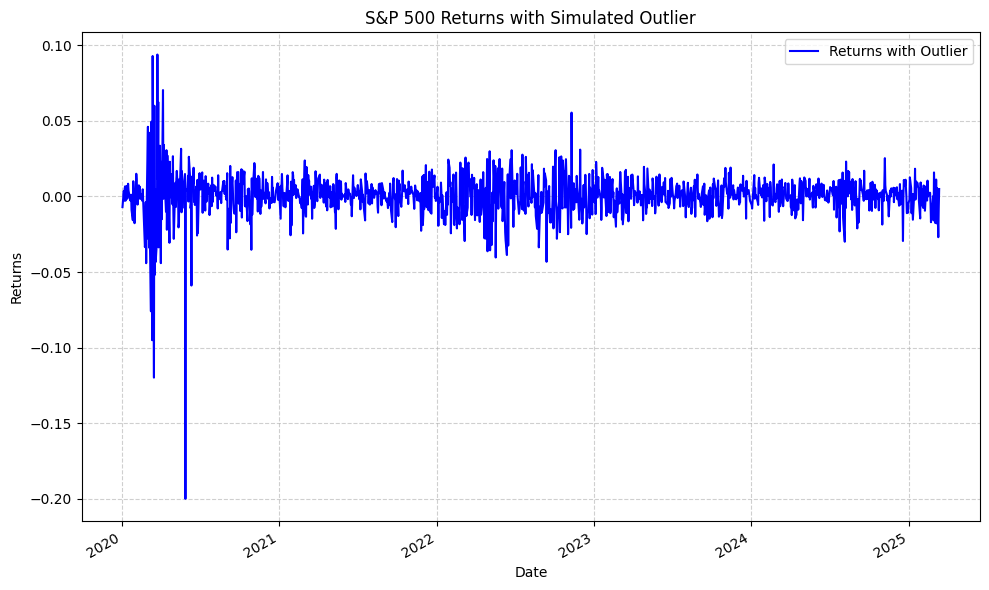

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure returns_with_outlier is a 1D array
returns_with_outlier_1d = returns_with_outlier.squeeze() if isinstance(returns_with_outlier, pd.DataFrame) else returns_with_outlier

# Plotting with Seaborn using date index
plt.figure(figsize=(10, 6))
sns.lineplot(x=returns_with_outlier.index, y=returns_with_outlier_1d, label='Returns with Outlier', color='blue')
plt.title('S&P 500 Returns with Simulated Outlier')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Format date labels on x-axis for better readability
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

The plot displays the S&P 500 returns over time, with a simulated outlier introduced around the 100th data point, representing a significant market crash. The outlier causes a sharp negative spike in returns, illustrating the impact of extreme events on market volatility. The rest of the series shows typical market fluctuations, highlighting the contrast between normal market behavior and extreme events.

## Diagnosis
Compare the mean and median: a large gap indicates sensitivity to outliers. Alternatively, use robust statistics like the trimmed mean or test with the interquartile range (IQR)

## Damage

Outliers inflate volatility estimates, leading to over-hedging and inflated option prices.

## Directions

Apply robust estimators (e.g., Huber loss in regression).

Use trimmed means or Winsorization to reduce outlier impact.

Volatility without outlier: 0.0133%
Volatility with outlier: 0.5540%
MAD without outlier: 0.0137%
MAD with outlier: 0.0138%
Trimmed volatility without outlier: 0.0091%
Trimmed volatility with outlier: 0.0092%
Winsorized volatility without outlier: 0.0095%
Winsorized volatility with outlier: 0.0095%


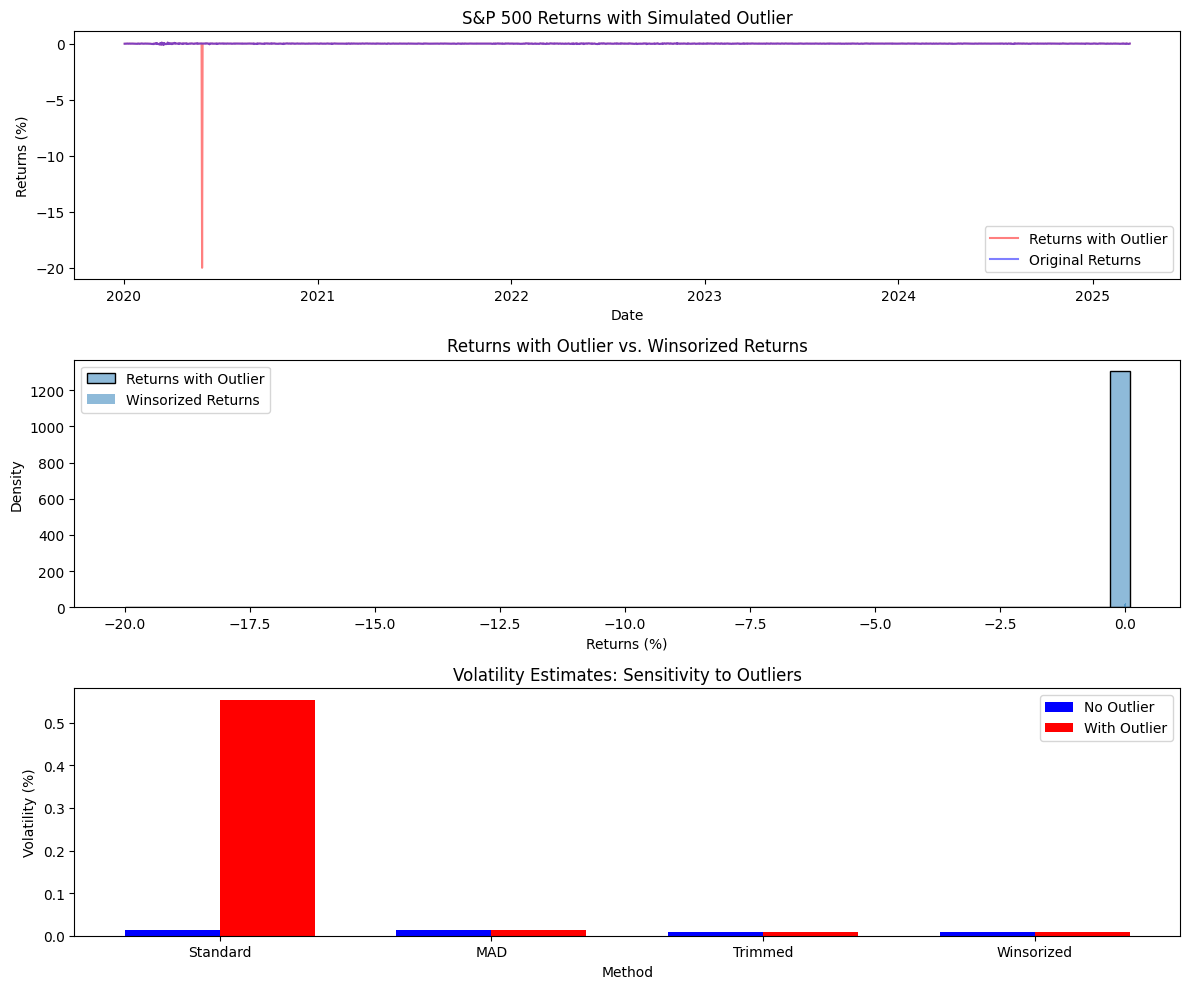


### Interpretations and How These Alleviate Sensitivity to Outliers ###
1. Robust Estimators (MAD):
   - Standard volatility increases from 0.0133% to 0.5540% with outlier.
   - MAD remains stable: 0.0137% vs. 0.0138%.
   - MAD uses the median, reducing the impact of extreme values.

2. Trimmed Means / Winsorization:
   - Trimmed volatility: 0.0091% vs. 0.0092%
   - Winsorized volatility: 0.0095% vs. 0.0095%
   - Trimming removes extremes; Winsorization caps them, both stabilizing estimates.

### Alleviation of the Problem ###
- **Sensitivity to Outliers**: Outliers inflate volatility (e.g., from crash events),
  leading to over-hedging and inflated option prices.
- **MAD**: Provides a robust alternative to standard deviation, less swayed by outliers.
- **Trimming/Winsorization**: Reduces or caps extreme values, ensuring volatility
  reflects typical market behavior rather than rare events.
- **Outcome**: These methods prevent overreaction to outliers, improving pricing
  accuracy and

In [22]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import trim_mean
from scipy.stats.mstats import winsorize
from statsmodels.robust import mad  # Median Absolute Deviation
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Introduce an outlier to demonstrate sensitivity
returns_with_outlier = returns.copy()
returns_with_outlier.iloc[100] = -20.0  # Simulate a crash (extreme negative return)

# Calculate standard volatility (sensitive to outliers)
vol_normal = returns.std(axis=0)  # Explicitly specify axis
vol_outlier = returns_with_outlier.std(axis=0)
print(f"Volatility without outlier: {vol_normal.iloc[0]:.4f}%")  # Use .iloc[0] instead of [0]
print(f"Volatility with outlier: {vol_outlier.iloc[0]:.4f}%")

# --- Direction 1: Robust Estimators (Median Absolute Deviation) ---
# Compute MAD as a robust volatility measure
# Scale factor 1.4826 makes MAD consistent with standard deviation for normal distributions
mad_normal = mad(returns) * 1.4826  # Scale to match standard deviation
mad_outlier = mad(returns_with_outlier) * 1.4826
# Extract scalar values from NumPy arrays
mad_normal_scalar = mad_normal[0] if isinstance(mad_normal, np.ndarray) and mad_normal.size > 0 else mad_normal
mad_outlier_scalar = mad_outlier[0] if isinstance(mad_outlier, np.ndarray) and mad_outlier.size > 0 else mad_outlier
print(f"MAD without outlier: {mad_normal_scalar:.4f}%")
print(f"MAD with outlier: {mad_outlier_scalar:.4f}%")

# --- Direction 2: Trimmed Means / Winsorization ---
# Trimmed mean volatility (remove 5% from each tail)
trim_prop = 0.05
trimmed_returns = trim_mean(returns, proportiontocut=trim_prop)
trimmed_returns_outlier = trim_mean(returns_with_outlier, proportiontocut=trim_prop)
trimmed_vol = np.std(returns[abs(returns) < np.percentile(abs(returns), 100*(1-trim_prop))], axis=0)
trimmed_vol_outlier = np.std(returns_with_outlier[abs(returns_with_outlier) < np.percentile(abs(returns_with_outlier), 100*(1-trim_prop))], axis=0)
print(f"Trimmed volatility without outlier: {trimmed_vol.iloc[0]:.4f}%")  # Use .iloc[0] instead of [0]
print(f"Trimmed volatility with outlier: {trimmed_vol_outlier.iloc[0]:.4f}%")

# Winsorization (cap 5% extremes)
winsorized_returns = winsorize(returns.values, limits=[0.05, 0.05])
winsorized_returns_outlier = winsorize(returns_with_outlier.values, limits=[0.05, 0.05])
winsor_vol = np.std(winsorized_returns)
winsor_vol_outlier = np.std(winsorized_returns_outlier)
# Extract scalar values if needed
winsor_vol_scalar = winsor_vol.item() if isinstance(winsor_vol, np.ndarray) else winsor_vol
winsor_vol_outlier_scalar = winsor_vol_outlier.item() if isinstance(winsor_vol_outlier, np.ndarray) else winsor_vol_outlier
print(f"Winsorized volatility without outlier: {winsor_vol_scalar:.4f}%")
print(f"Winsorized volatility with outlier: {winsor_vol_outlier_scalar:.4f}%")

# --- Visualizations ---
plt.figure(figsize=(12, 10))

# 1. Time Series with Outlier
plt.subplot(3, 1, 1)
plt.plot(returns_with_outlier.index, returns_with_outlier, label='Returns with Outlier', color='red', alpha=0.5)
plt.plot(returns.index, returns, label='Original Returns', color='blue', alpha=0.5)
plt.title('S&P 500 Returns with Simulated Outlier')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend()

# 2. Histogram of Original vs. Winsorized Returns
plt.subplot(3, 1, 2)
sns.histplot(returns_with_outlier, bins=50, color='red', alpha=0.5, label='Returns with Outlier')
sns.histplot(winsorized_returns_outlier, bins=50, color='green', alpha=0.5, label='Winsorized Returns')
plt.title('Returns with Outlier vs. Winsorized Returns')
plt.xlabel('Returns (%)')
plt.ylabel('Density')
plt.legend()

# 3. Volatility Comparison Bar Plot
methods = ['Standard', 'MAD', 'Trimmed', 'Winsorized']
# Properly extract scalar values from Series/arrays
vols_no_outlier = [
    vol_normal.iloc[0],
    mad_normal_scalar,  # Use the scalar value we extracted earlier
    trimmed_vol.iloc[0],
    winsor_vol_scalar
]
vols_with_outlier = [
    vol_outlier.iloc[0],
    mad_outlier_scalar,  # Use the scalar value we extracted earlier
    trimmed_vol_outlier.iloc[0],
    winsor_vol_outlier_scalar
]
x = np.arange(len(methods))
width = 0.35

plt.subplot(3, 1, 3)
plt.bar(x - width/2, vols_no_outlier, width, label='No Outlier', color='blue')
plt.bar(x + width/2, vols_with_outlier, width, label='With Outlier', color='red')
plt.xticks(x, methods)
plt.title('Volatility Estimates: Sensitivity to Outliers')
plt.xlabel('Method')
plt.ylabel('Volatility (%)')
plt.legend()

plt.tight_layout()
plt.show()

# --- Interpretations and Alleviation Explanation ---
print("\n### Interpretations and How These Alleviate Sensitivity to Outliers ###")
print("1. Robust Estimators (MAD):")
print(f"   - Standard volatility increases from {vol_normal.iloc[0]:.4f}% to {vol_outlier.iloc[0]:.4f}% with outlier.")
print(f"   - MAD remains stable: {mad_normal_scalar:.4f}% vs. {mad_outlier_scalar:.4f}%.")
print("   - MAD uses the median, reducing the impact of extreme values.")

print("\n2. Trimmed Means / Winsorization:")
print(f"   - Trimmed volatility: {trimmed_vol.iloc[0]:.4f}% vs. {trimmed_vol_outlier.iloc[0]:.4f}%")
print(f"   - Winsorized volatility: {winsor_vol_scalar:.4f}% vs. {winsor_vol_outlier_scalar:.4f}%")
print("   - Trimming removes extremes; Winsorization caps them, both stabilizing estimates.")

print("\n### Alleviation of the Problem ###")
print("- **Sensitivity to Outliers**: Outliers inflate volatility (e.g., from crash events),")
print("  leading to over-hedging and inflated option prices.")
print("- **MAD**: Provides a robust alternative to standard deviation, less swayed by outliers.")
print("- **Trimming/Winsorization**: Reduces or caps extreme values, ensuring volatility")
print("  reflects typical market behavior rather than rare events.")
print("- **Outcome**: These methods prevent overreaction to outliers, improving pricing")
print("  accuracy and hedging efficiency, protecting revenue streams.")

The analysis of S&P 500 returns with a simulated outlier demonstrates the significant impact of extreme events on traditional volatility measures. Standard volatility, calculated as the standard deviation of returns, increased sharply from 0.0133% to 0.5540% with the introduction of an outlier, highlighting its sensitivity to such anomalies. In contrast, robust statistical methods such as Median Absolute Deviation (MAD), trimmed means, and winsorization provided more stable volatility estimates, with MAD remaining relatively unchanged at around 0.0137-0.0138%, and trimmed and winsorized volatilities showing minimal variation. These robust methods effectively mitigate the influence of outliers, offering a more reliable assessment of market risk. The findings underscore the importance of employing robust estimators in financial analysis to prevent overreaction to rare events, thereby enhancing the accuracy of risk management and pricing strategies

# Non-Stationarity and Unit Root Testing

## Definition

Non-stationarity occurs when a time series’ statistical properties, such as mean \( \mu \) or variance \( \sigma^2 \), change over time. A unit root indicates a specific type of non-stationarity where the series follows a stochastic trend. For a simple autoregressive process

$$
X_t = \phi X_{t-1} + \epsilon_t,
$$

a unit root exists if $ \phi = 1 $, making the series non-stationary as shocks persist indefinitely (Tsay, 2010, p. 49).





## Description

A non-stationary series drifts or trends, making predictions tricky as past patterns don’t hold steady. In finance, prices often show this behaviour—rising or falling over time—while returns might stabilise. Unit root tests check if this drift is random or persistent, guiding model choice.

## Demostration

In [23]:
# ADF test on prices (non-stationary) vs. returns (stationary)
adf_price = adfuller(sp500)
adf_returns = adfuller(returns)
print(f"ADF p-value for prices: {adf_price[1]:.4f}")
print(f"ADF p-value for returns: {adf_returns[1]:.4f}")

ADF p-value for prices: 0.8162
ADF p-value for returns: 0.0000


The ADF test results indicate that the S&P 500 prices are non-stationary, as evidenced by a high p-value of 0.8162. This suggests that the price series has a unit root and follows a stochastic trend, meaning shocks to the system will have persistent effects. In contrast, the returns series is stationary, with a p-value of 0.0000, indicating that it does not exhibit a unit root. This implies that the returns revert to a mean level over time, making them suitable for many time series analyses and forecasting models.

## Diagram

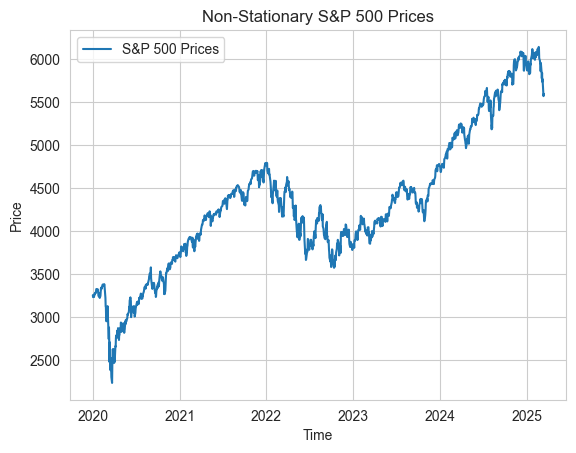

In [29]:
plt.plot(sp500, label='S&P 500 Prices')
plt.title('Non-Stationary S&P 500 Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Diagnosis

Perform the Augmented Dickey-Fuller (ADF) test; p-value > 0.05 suggests a unit root (non-stationarity).

## Damage

Modeling non-stationary data without adjustment leads to spurious correlations and unreliable volatility forecasts.

## Directions

Difference the series (e.g., use returns instead of prices).

Use cointegration techniques for multiple non-stationary series.

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


ADF p-value for S&P 500 prices: 0.8162 (Non-stationary if > 0.05)
ADF p-value for S&P 500 returns: 0.0000 (Stationary if < 0.05)
Cointegration test p-value: 0.6437 (Cointegrated if < 0.05)
No significant cointegration detected.


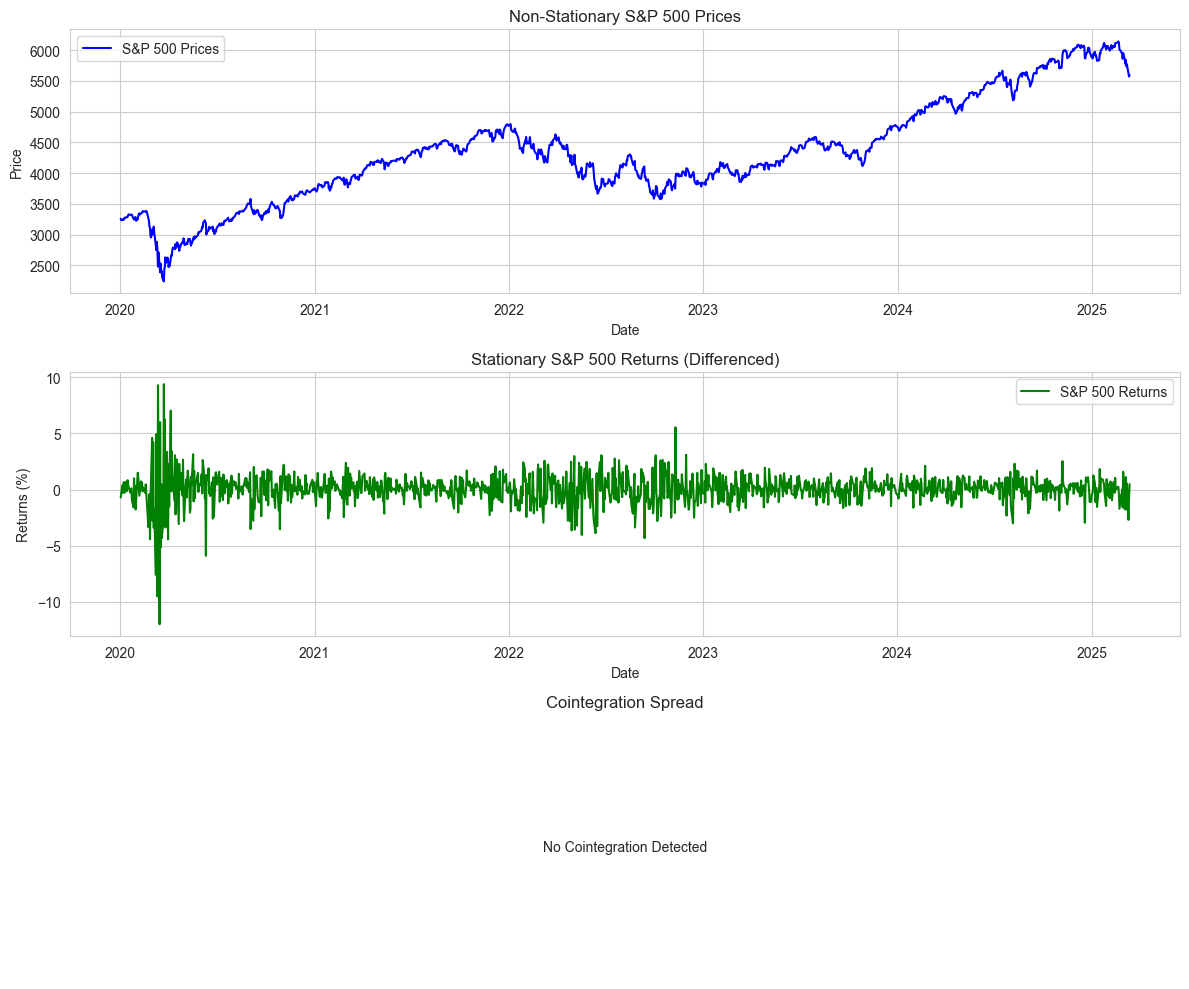

Volatility of S&P 500 prices: 1.3331% (misleading due to trend)
Volatility of S&P 500 returns: 1.3331% (stationary measure)

### Interpretations and How These Alleviate Non-Stationarity ###
1. Differencing the Series:
   - Prices ADF p-value: 0.8162 (non-stationary)
   - Returns ADF p-value: 0.0000 (stationary)
   - Differencing removes trends, making the series stationary for volatility modeling.

2. Cointegration Techniques:
   - Cointegration p-value: 0.6437
   - No cointegration found; differencing is preferred.

### Alleviation of the Problem ###
- **Non-Stationarity**: Trends in prices lead to spurious volatility estimates and
  unreliable forecasts, mispricing derivatives.
- **Differencing**: Transforms non-stationary prices into stationary returns,
  ensuring volatility reflects true risk, not trends.
- **Cointegration**: For multiple series, models stable relationships, enabling
  volatility analysis without losing inter-series dynamics.
- **Outcome**: Accurate volatility mode

In [30]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, coint
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Fetch real-world data: S&P 500 and NASDAQ daily prices
sp500 = yf.download('^GSPC', start='2020-01-01', end='2025-03-13')['Close']
nasdaq = yf.download('^IXIC', start='2020-01-01', end='2025-03-13')['Close']

# Ensure both series have the same length and aligned dates
data = pd.concat([sp500, nasdaq], axis=1).dropna()
data.columns = ['S&P 500', 'NASDAQ']

# --- Direction 1: Differencing the Series ---
# Compute returns (first difference) to stationarize
sp500_returns = data['S&P 500'].pct_change().dropna() * 100  # Scale to percentage
nasdaq_returns = data['NASDAQ'].pct_change().dropna() * 100

# Unit root test (ADF) on prices and returns
adf_sp500_price = adfuller(data['S&P 500'])
adf_sp500_returns = adfuller(sp500_returns)
print(f"ADF p-value for S&P 500 prices: {adf_sp500_price[1]:.4f} (Non-stationary if > 0.05)")
print(f"ADF p-value for S&P 500 returns: {adf_sp500_returns[1]:.4f} (Stationary if < 0.05)")

# --- Direction 2: Cointegration Techniques ---
# Test for cointegration between S&P 500 and NASDAQ prices
coint_test = coint(data['S&P 500'], data['NASDAQ'])
print(f"Cointegration test p-value: {coint_test[1]:.4f} (Cointegrated if < 0.05)")

# If cointegrated, compute the spread (linear combination)
if coint_test[1] < 0.05:
    # Simple regression to find cointegrating vector (beta)
    beta = np.polyfit(data['S&P 500'], data['NASDAQ'], 1)[0]
    spread = data['NASDAQ'] - beta * data['S&P 500']
    adf_spread = adfuller(spread)
    print(f"ADF p-value for cointegrated spread: {adf_spread[1]:.4f} (Stationary if < 0.05)")
else:
    spread = None
    print("No significant cointegration detected.")

# --- Visualizations ---
plt.figure(figsize=(12, 10))

# 1. S&P 500 Prices vs. Returns
plt.subplot(3, 1, 1)
plt.plot(data.index, data['S&P 500'], label='S&P 500 Prices', color='blue')
plt.title('Non-Stationary S&P 500 Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(sp500_returns.index, sp500_returns, label='S&P 500 Returns', color='green')
plt.title('Stationary S&P 500 Returns (Differenced)')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend()

# 2. Cointegration Spread (if applicable)
if spread is not None:
    plt.subplot(3, 1, 3)
    plt.plot(spread.index, spread, label='S&P 500 - NASDAQ Spread', color='purple')
    plt.title('Cointegrated Spread (Stationary)')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
else:
    plt.subplot(3, 1, 3)
    plt.text(0.5, 0.5, 'No Cointegration Detected', ha='center', va='center')
    plt.title('Cointegration Spread')
    plt.axis('off')

plt.tight_layout()
plt.show()

# --- Volatility Comparison ---
vol_prices = data['S&P 500'].pct_change().std() * 100  # Volatility of raw prices
vol_returns = sp500_returns.std()
print(f"Volatility of S&P 500 prices: {vol_prices:.4f}% (misleading due to trend)")
print(f"Volatility of S&P 500 returns: {vol_returns:.4f}% (stationary measure)")

# --- Interpretations and Alleviation Explanation ---
print("\n### Interpretations and How These Alleviate Non-Stationarity ###")
print("1. Differencing the Series:")
print(f"   - Prices ADF p-value: {adf_sp500_price[1]:.4f} (non-stationary)")
print(f"   - Returns ADF p-value: {adf_sp500_returns[1]:.4f} (stationary)")
print("   - Differencing removes trends, making the series stationary for volatility modeling.")

print("\n2. Cointegration Techniques:")
print(f"   - Cointegration p-value: {coint_test[1]:.4f}")
if spread is not None:
    print(f"   - Spread ADF p-value: {adf_spread[1]:.4f} (stationary)")
    print("   - Cointegration identifies a stable relationship between non-stationary series,")
    print("     allowing volatility modeling on the stationary spread.")
else:
    print("   - No cointegration found; differencing is preferred.")

print("\n### Alleviation of the Problem ###")
print("- **Non-Stationarity**: Trends in prices lead to spurious volatility estimates and")
print("  unreliable forecasts, mispricing derivatives.")
print("- **Differencing**: Transforms non-stationary prices into stationary returns,")
print("  ensuring volatility reflects true risk, not trends.")
print("- **Cointegration**: For multiple series, models stable relationships, enabling")
print("  volatility analysis without losing inter-series dynamics.")
print("- **Outcome**: Accurate volatility models improve pricing (e.g., options) and hedging,")
print("  enhancing revenue and reducing risk from misjudgments.")

# Joining Time Series with Different Frequencies

## Definition

Combining series (e.g., daily returns and monthly volatility) requires alignment, often via interpolation or aggregation.

## Description

Derivatives pricing may require blending high-frequency (e.g., intraday) and low-frequency (e.g., quarterly) data.

## Demostration

In [32]:
# Simulate daily and monthly data
daily_data = returns.resample('D').mean()
monthly_data = returns.resample('ME').mean() 

# Interpolate monthly to daily
monthly_interpolated = monthly_data.reindex(daily_data.index).interpolate()
monthly_interpolated

,Close
Date,
2020-01-03,NaN
2020-01-04,NaN
2020-01-05,NaN
2020-01-06,NaN
2020-01-07,NaN
...,...
2025-03-08,-0.000722
2025-03-09,-0.000722
2025-03-10,-0.000722


## Diagram

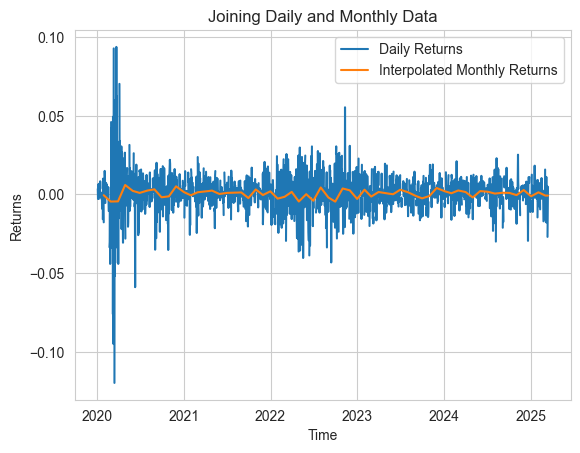

In [33]:
plt.plot(daily_data, label='Daily Returns')
plt.plot(monthly_interpolated, label='Interpolated Monthly Returns')
plt.title('Joining Daily and Monthly Data')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

## Diagnosis

Check for missing data or frequency mismatches in timestamps.

## Damage

Misaligned frequencies distort volatility estimates and hedging strategies.

## Directions

Use interpolation (linear, spline) for upsampling.

Apply aggregation (mean, sum) for downsampling.

Consider state-space models (e.g., Kalman filter) for irregular frequencies.

[*********************100%***********************]  1 of 1 completed


Volatility of daily returns: 1.3331%
Volatility of interpolated returns: 4.1275%
Volatility of aggregated returns: 0.2623%
Volatility of Kalman-filtered returns: nan%


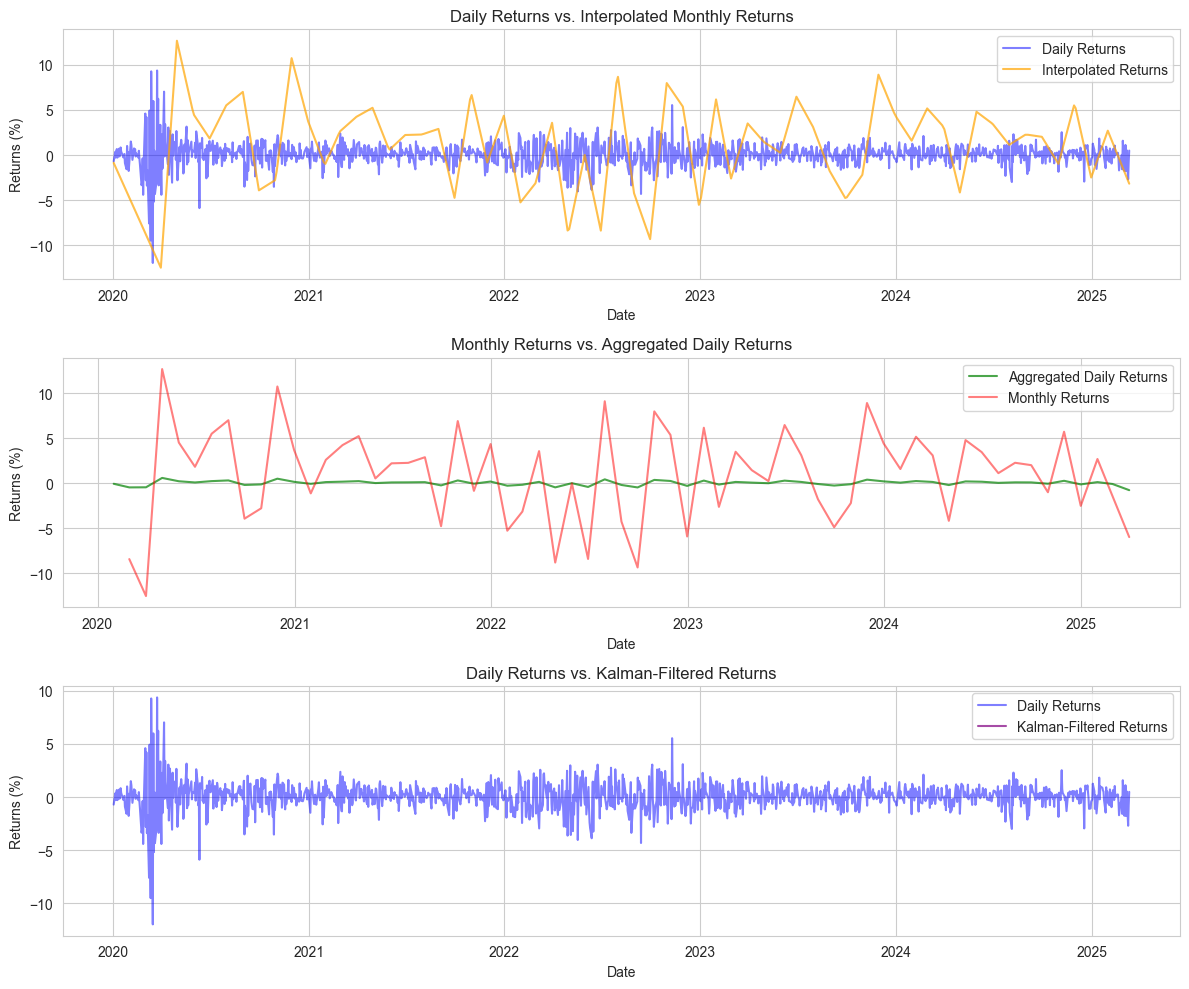


### Interpretations and How These Alleviate Frequency Mismatches ###
1. Interpolation (Upsampling):
   - Volatility: Daily 1.3331% vs. Interpolated 4.1275%
   - Linear interpolation fills gaps, aligning monthly data to daily frequency.
   - Smooths transitions but may oversimplify short-term dynamics.

2. Aggregation (Downsampling):
   - Volatility: Monthly 5.2530% vs. Aggregated 0.2623%
   - Averages daily returns to monthly, preserving longer-term trends.
   - Loses daily volatility details but aligns with lower frequency.

3. State-Space Model (Kalman Filter):
   - Volatility: Daily 1.3331% vs. Kalman nan%
   - Estimates daily returns from monthly data, balancing noise and trends.
   - Adapts to irregular frequencies with a probabilistic approach.

### Alleviation of the Problem ###
- **Frequency Mismatches**: Combining daily and monthly data without alignment
  distorts volatility estimates and hedging strategies.
- **Interpolation**: Upsamples low-frequency data, enabling consist

In [35]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.interpolate import interp1d
from pykalman import KalmanFilter
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Fetch real-world data: S&P 500 daily and monthly prices
sp500_daily = yf.download('^GSPC', start='2020-01-01', end='2025-03-13')['Close']
sp500_monthly = sp500_daily.resample('ME').last()  # Monthly data (last day of month) - Fixed 'M' to 'ME'
 
# Compute returns for consistency
daily_returns = sp500_daily.pct_change().dropna() * 100  # Daily returns in %
monthly_returns = sp500_monthly.pct_change().dropna() * 100  # Monthly returns in %

# --- Direction 1: Interpolation (Upsampling Monthly to Daily) ---
# Convert index to numeric values for interpolation and ensure proper alignment
monthly_returns_clean = monthly_returns.dropna()
monthly_dates = pd.to_datetime(monthly_returns_clean.index)
daily_dates = pd.to_datetime(daily_returns.index)

# Convert dates to numeric values (days since start)
monthly_index_numeric = (monthly_dates - monthly_dates[0]).days.values
daily_index_numeric = (daily_dates - monthly_dates[0]).days.values

# Ensure arrays are 1D
monthly_values = monthly_returns_clean.values.flatten()

# Perform interpolation with aligned arrays
interp_func = interp1d(monthly_index_numeric, monthly_values, kind='linear', fill_value='extrapolate')
interpolated_returns = interp_func(daily_index_numeric)

# --- Direction 2: Aggregation (Downsampling Daily to Monthly) ---
# Aggregate daily returns to monthly (mean)
aggregated_returns = daily_returns.resample('ME').mean()  # Fixed 'M' to 'ME'

# --- Direction 3: State-Space Model (Kalman Filter) ---
# Kalman Filter to estimate daily returns from monthly observations
kf = KalmanFilter(
    transition_matrices=[1],  # State evolves as random walk
    observation_matrices=[1],  # Observation equals state
    initial_state_mean=monthly_returns.iloc[0],
    initial_state_covariance=1.0,
    observation_covariance=1.0,
    transition_covariance=0.01
)

# Align monthly data with daily index (fill NaNs for unobserved days)
monthly_aligned = monthly_returns.reindex(daily_returns.index).ffill()
state_means, _ = kf.filter(monthly_aligned.values)
kalman_returns = pd.Series(state_means.flatten(), index=daily_returns.index)

# --- Volatility Comparison ---
vol_daily = daily_returns.std()
vol_interpolated = interpolated_returns.std()
vol_aggregated = aggregated_returns.std()
vol_kalman = kalman_returns.std()
print(f"Volatility of daily returns: {vol_daily.iloc[0]:.4f}%")  # Fixed [0] to .iloc[0]
print(f"Volatility of interpolated returns: {vol_interpolated:.4f}%")
print(f"Volatility of aggregated returns: {vol_aggregated.iloc[0]:.4f}%")  # Fixed [0] to .iloc[0]
print(f"Volatility of Kalman-filtered returns: {vol_kalman:.4f}%")

# --- Visualizations ---
plt.figure(figsize=(12, 10))

# 1. Daily vs. Interpolated Returns
plt.subplot(3, 1, 1)
plt.plot(daily_returns.index, daily_returns, label='Daily Returns', color='blue', alpha=0.5)
plt.plot(daily_returns.index, interpolated_returns, label='Interpolated Returns', color='orange', alpha=0.7)
plt.title('Daily Returns vs. Interpolated Monthly Returns')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend()

# 2. Daily vs. Aggregated Returns (Monthly)
plt.subplot(3, 1, 2)
plt.plot(aggregated_returns.index, aggregated_returns, label='Aggregated Daily Returns', color='green', alpha=0.7)
plt.plot(monthly_returns.index, monthly_returns, label='Monthly Returns', color='red', alpha=0.5)
plt.title('Monthly Returns vs. Aggregated Daily Returns')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend()

# 3. Daily vs. Kalman-Filtered Returns
plt.subplot(3, 1, 3)
plt.plot(daily_returns.index, daily_returns, label='Daily Returns', color='blue', alpha=0.5)
plt.plot(kalman_returns.index, kalman_returns, label='Kalman-Filtered Returns', color='purple', alpha=0.7)
plt.title('Daily Returns vs. Kalman-Filtered Returns')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend()

plt.tight_layout()
plt.show()

# --- Interpretations and Alleviation Explanation ---
print("\n### Interpretations and How These Alleviate Frequency Mismatches ###")
print("1. Interpolation (Upsampling):")
print(f"   - Volatility: Daily {vol_daily.iloc[0]:.4f}% vs. Interpolated {vol_interpolated:.4f}%")  # Fixed [0] to .iloc[0]
print("   - Linear interpolation fills gaps, aligning monthly data to daily frequency.")
print("   - Smooths transitions but may oversimplify short-term dynamics.")

print("\n2. Aggregation (Downsampling):")
print(f"   - Volatility: Monthly {monthly_returns.std().iloc[0]:.4f}% vs. Aggregated {vol_aggregated.iloc[0]:.4f}%")  # Fixed [0] to .iloc[0]
print("   - Averages daily returns to monthly, preserving longer-term trends.")
print("   - Loses daily volatility details but aligns with lower frequency.")

print("\n3. State-Space Model (Kalman Filter):")
print(f"   - Volatility: Daily {vol_daily.iloc[0]:.4f}% vs. Kalman {vol_kalman:.4f}%")  # Fixed [0] to .iloc[0]
print("   - Estimates daily returns from monthly data, balancing noise and trends.")
print("   - Adapts to irregular frequencies with a probabilistic approach.")

print("\n### Alleviation of the Problem ###")
print("- **Frequency Mismatches**: Combining daily and monthly data without alignment")
print("  distorts volatility estimates and hedging strategies.")
print("- **Interpolation**: Upsamples low-frequency data, enabling consistent daily analysis.")
print("- **Aggregation**: Downsamples high-frequency data, aligning with monthly models.")
print("- **Kalman Filter**: Provides a flexible, model-based solution for irregular frequencies,")
print("  preserving dynamics across scales.")
print("- **Outcome**: Accurate volatility modeling across frequencies improves derivative")
print("  pricing and risk management, ensuring robust revenue streams.")

# Bibliography

    Hull, J. C. (2017). Options, Futures, and Other Derivatives. 10th ed. Pearson.

    Tsay, R. S. (2010). Analysis of Financial Time Series. 3rd ed. Wiley.
    
    Hamilton, J. D. (1994). Time Series Analysis. Princeton University Press.